<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/KFold_%22LM%2C_Ridge%2C_DT%2C_RF%2C_XGB%2Bneer_cpi_2002_2019%22%22%2004.02.2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

!pip install pmdarima -q
#from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

In [69]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

# **Переменные**

In [70]:
cpi = "month"
reg_names = ['RF']
data_do = "2019-12-01"
train_do = "2018-01-01"
mes = (pd.to_datetime(data_do).to_period('M') - pd.to_datetime(train_do).to_period('M')).n +1

result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'mes', 'method', 'rmse'])

In [71]:
data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)
data.isna().sum().sum()
data.tail(6)

,RF,BEL,BRY,VLA,VOR,IVA,KAL,KOS,KUR,LIP,MOS,ORL,RYA,SMO,TAM,TVE,TUL,YAR,MOW,KAR,KOM,ARK,VLG,KAG,LEN,MUR,NGR,PSK,SPB,ADY,KLM,KRA,AST,VGG,ROS,DAG,ING,KAB,KAO,NOR,STA,BAS,MAR,MOR,TAT,UDM,CHV,PER,KIR,NIZ,ORE,PNZ,SAM,SAR,ULY,KUG,SVE,TYU,CHE,ALI,TUV,KHK,ALT,KYA,IRK,KEM,NVS,OMS,TOM,BUR,SAH,ZAB,KAM,PRI,KHA,AMU,MAG,SAK,JEW,CHU
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,100.83,100.95,100.80,100.91,101.06,100.88,101.34,100.69,101.32,101.04,100.65,101.10,101.30,101.40,101.29,101.22,101.07,100.50,100.44,100.85,100.80,100.95,100.83,100.86,100.79,100.91,100.78,100.79,100.74,100.82,101.55,101.10,101.24,101.25,101.02,101.36,101.48,101.30,100.70,101.28,100.70,101.09,100.79,100.63,100.70,100.67,101.47,100.88,101.14,101.14,100.93,101.11,100.82,101.29,100.91,100.87,100.88,100.67,100.76,100.94,100.88,101.10,100.39,100.63,101.08,100.67,100.84,100.78,100.78,100.94,100.20,100.96,100.51,100.94,100.83,101.05,100.40,100.59,101.06,100.31
2020-05-01,100.27,100.38,100.36,100.05,100.54,100.25,100.12,100.36,100.41,100.24,100.43,100.17,100.05,100.24,100.24,100.27,100.10,100.33,100.48,100.25,100.70,100.33,100.15,100.15,100.18,100.21,100.21,100.55,100.09,100.71,100.75,100.11,100.56,99.97,100.36,99.83,100.21,100.12,100.11,100.19,100.27,100.17,100.26,100.33,100.19,100.32,100.20,100.12,100.09,100.26,100.20,99.87,100.20,100.14,100.43,100.23,100.15,100.22,100.25,100.18,100.10,100.23,100.33,100.12,100.48,100.19,100.32,100.14,100.30,100.33,100.47,100.39,100.30,100.18,100.03,100.53,100.45,100.16,100.03,100.11
2020-06-01,100.22,100.13,100.40,100.35,100.21,100.24,100.26,100.35,100.48,100.25,100.35,100.17,100.40,100.05,100.24,100.68,99.84,100.53,100.35,100.41,100.29,100.19,100.25,100.22,99.96,100.15,100.02,99.85,100.00,100.28,100.36,100.08,100.13,100.31,100.50,99.41,100.13,100.01,100.01,100.19,100.05,100.11,100.32,100.22,100.24,100.31,100.30,100.33,100.70,100.35,100.09,100.28,100.19,100.22,100.48,100.17,100.10,100.05,100.28,100.32,100.28,100.28,100.32,100.09,99.76,100.13,100.22,100.31,100.19,100.45,100.49,100.18,100.20,100.15,100.44,99.95,100.33,100.17,100.83,100.00
2020-07-01,100.35,100.53,100.41,100.42,100.43,100.48,100.13,100.50,100.47,100.44,100.28,100.36,100.51,100.54,100.42,100.15,100.37,100.52,100.35,100.86,100.21,100.09,100.59,100.62,100.77,100.48,100.74,100.79,100.53,100.01,99.51,100.44,100.21,100.15,100.04,99.82,99.76,99.85,100.12,99.53,100.32,100.22,100.53,100.43,100.37,100.40,100.19,100.01,100.21,100.34,100.25,100.45,100.66,100.35,100.42,100.39,100.41,100.20,100.58,100.09,100.76,100.47,100.50,100.47,100.24,99.87,100.18,100.30,100.45,100.78,100.18,100.66,100.21,100.47,100.28,100.80,101.34,100.45,99.90,100.17
2020-08-01,99.96,99.95,99.82,99.65,99.93,100.02,99.97,99.94,99.53,99.98,99.77,99.92,99.86,99.51,99.93,99.56,99.76,99.68,99.97,99.88,99.76,99.75,99.68,100.26,99.81,99.66,99.87,100.08,99.86,99.99,99.76,100.42,99.60,99.59,99.85,100.40,99.98,100.11,100.02,99.87,99.92,99.99,100.01,99.89,100.04,99.91,99.70,100.20,99.96,99.70,100.30,100.08,100.05,99.74,100.03,100.18,99.97,99.94,100.12,100.35,99.79,100.16,100.06,99.80,100.32,99.80,100.00,100.10,99.69,99.96,100.15,100.17,100.43,100.02,100.02,100.37,99.58,99.92,100.03,100.05
2020-09-01,99.93,100.09,99.77,99.99,100.10,99.86,99.85,99.89,99.69,100.18,99.79,99.96,99.94,99.95,99.99,99.91,99.74,99.79,99.91,99.77,99.68,99.90,99.89,99.71,99.75,99.93,99.86,99.73,99.83,100.48,99.92,99.80,100.19,100.20,99.93,99.72,99.89,100.13,99.91,100.05,100.07,100.07,99.84,99.73,100.06,100.02,99.89,99.76,99.86,100.14,99.83,100.03,99.98,99.84,99.78,100.11,100.02,99.68,99.76,99.88,99.87,100.34,99.73,100.10,99.98,100.73,99.71,99.86,100.27,99.95,100.56,99.41,99.95,100.27,100.19,99.99,99.88,100.31,100.58,99.61


# **Проверка на стационарность**

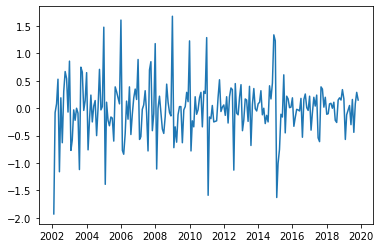

In [72]:
# to log  and diff
data_st = pd.DataFrame(index = data.index[1:])
#data_st = pd.DataFrame(index = data.index)

for region in data.columns:
#  data_st[region] = np.log(data[region].values)
#  data_st[region] = np.diff(np.log(data[region].values))
  data_st[region] = np.diff(data[region].values)
data_st=(data_st[:-10])

plt.plot(data_st[reg_names])

In [73]:
"""
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
st = 0
notst = 0
p_value = 0.01
for num, region in enumerate(data_st.keys()):
  if region == 'RF':
    continue
  adf_result = adfuller(data_st[region])
  result_text = []
  result_text.append('ADF: {:.5}, '.format(adf_result[0]))
  result_text.append('p-val: {:.2}, '.format(adf_result[1]))
  if adf_result[1] < float(p_value):
      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      st += 1
  else:
      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      notst += 1
print('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\n%matplotlib inline\nst = 0\nnotst = 0\np_value = 0.01\nfor num, region in enumerate(data_st.keys()):\n  if region == 'RF':\n    continue\n  adf_result = adfuller(data_st[region])\n  result_text = []\n  result_text.append('ADF: {:.5}, '.format(adf_result[0]))\n  result_text.append('p-val: {:.2}, '.format(adf_result[1]))\n  if adf_result[1] < float(p_value):\n      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      st += 1\n  else:\n      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      notst += 1\nprint('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)\n"

In [74]:
#if use stationary data
#data=data_st
"""
# для стационарных рядов
data_st = data_st[reg_names]
data_st = data_st[:data_do]
data_st = data_st.merge(course_m, left_on='date', right_on='date')
data_st['month'] = pd.DatetimeIndex(data_st.index).month
train_st = data_st[data_st.index < train_do]
test_st = data_st[data_st.index >= train_do]
"""
# for ML
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')
data['month'] = pd.DatetimeIndex(data.index).month

train = data[data.index < train_do]
test = data[data.index >= train_do]


# **ARIMA**

In [75]:
exogenous_features = ['month', 'curs']

In [76]:
  # find best params for ARIMA
  stepwise_model = auto_arima (train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, 
                               D=1, d=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True,  \
                               out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))


Performing stepwise search to minimize aicc
 ARIMA(1,1,1)(0,1,1)[12]             : AICC=158.569, Time=1.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AICC=267.173, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AICC=223.093, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AICC=inf, Time=0.82 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AICC=inf, Time=0.60 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AICC=159.660, Time=1.95 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AICC=159.153, Time=4.23 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AICC=inf, Time=1.21 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AICC=162.468, Time=5.96 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AICC=inf, Time=0.72 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AICC=158.427, Time=1.47 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AICC=inf, Time=0.61 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AICC=159.422, Time=2.37 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AICC=158.993, Time=4.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             :

KeyboardInterrupt: ignored

In [ ]:
result = pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])
result_arima = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMA', 'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arima, ignore_index = True) 
result_rmse

# **ARIMAX**

In [ ]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], start_p=1, start_q=1, 
                            max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, \
                            out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [ ]:
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])

In [ ]:
result_arimax = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMAX', 
                'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arimax, ignore_index = True) 
result_rmse

# **Feature Engineering**

In [82]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in {1, 6, 12}:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
    
data_lags.index = data.index
#data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags.head(24)

,curs,t,t-1,t-12,t-6,month
date,,,,,,
2002-01-01,30.472715,103.09,NaN,NaN,NaN,1
2002-02-01,30.805700,101.16,103.09,NaN,NaN,2
2002-03-01,31.064267,101.08,101.16,NaN,NaN,3
2002-04-01,31.173586,101.16,101.08,NaN,NaN,4
2002-05-01,31.254884,101.69,101.16,NaN,NaN,5
2002-06-01,31.404930,100.53,101.69,NaN,NaN,6
2002-07-01,31.514986,100.72,100.53,NaN,103.09,7
2002-08-01,31.554309,100.09,100.72,NaN,101.16,8
2002-09-01,31.626655,100.40,100.09,NaN,101.08,9


In [ ]:
df=data_lags
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("date", drop=True, inplace=True)
df.head(12)

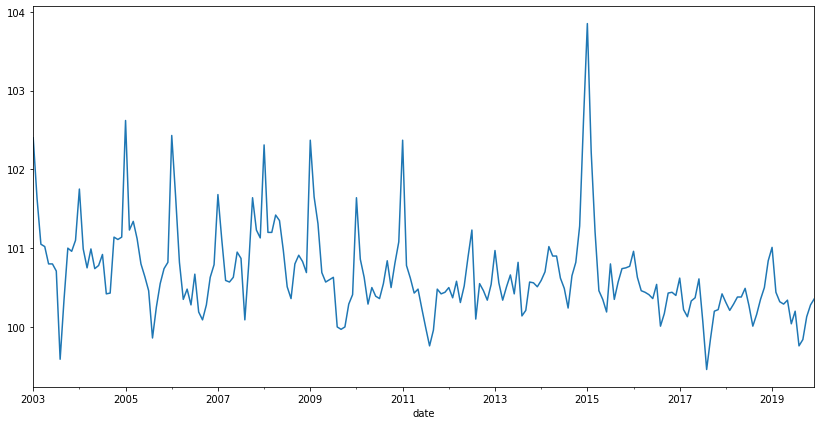

In [25]:
df.t.plot(figsize=(14, 7))

In [26]:
data = df
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()

In [63]:
test

,curs,t,t-1,t-12,t-6,month,t_mean_lag3,t_mean_lag6,t_mean_lag12,t_std_lag3,t_std_lag6,t_std_lag12,curs_mean_lag3,curs_mean_lag6,curs_mean_lag12,curs_std_lag3,curs_std_lag6,curs_std_lag12
date,,,,,,,,,,,,,,,,,,
2018-01-01,56.498100,100.31,100.42,100.62,100.07,1,100.279999,100.036667,100.208336,0.121655,0.339333,0.320591,58.399487,58.708092,58.308605,0.632540,0.871990,1.052089
2018-02-01,56.806705,100.21,100.31,100.22,99.46,2,100.316666,100.076668,100.182503,0.100167,0.357696,0.295946,57.999504,58.175663,58.047626,1.312157,1.096869,1.082535
2018-03-01,57.063605,100.29,100.21,100.13,99.85,3,100.313332,100.201668,100.181664,0.105040,0.191564,0.295845,57.292885,57.707993,57.903236,1.120031,0.949969,1.125676
2018-04-01,60.769890,100.38,100.29,100.33,100.20,4,100.269997,100.275002,100.195000,0.052915,0.084083,0.296908,56.789471,57.594479,57.824654,0.283146,0.984762,1.150447
2018-05-01,62.230900,100.38,100.38,100.37,100.22,5,100.293335,100.305000,100.199165,0.085049,0.084083,0.299316,58.213402,58.106453,58.185841,2.217709,1.633928,1.339549
2018-06-01,62.768505,100.49,100.38,100.61,100.42,6,100.349998,100.331665,100.199997,0.051962,0.076790,0.299848,60.021465,58.657177,58.625912,2.663708,2.360819,1.712248
2018-07-01,62.861948,100.27,100.49,100.07,100.31,7,100.416664,100.343330,100.190002,0.063509,0.095847,0.286642,61.923100,59.356285,59.032188,1.034249,2.892435,2.064708
2018-08-01,66.076409,100.01,100.27,99.46,100.21,8,100.379997,100.336670,100.206665,0.110000,0.099933,0.284839,62.620449,60.416927,59.296295,0.340581,2.800057,2.341075
2018-09-01,67.666095,100.16,100.01,99.85,100.29,9,100.256668,100.303337,100.252502,0.240278,0.163666,0.177975,63.902287,61.961876,59.834934,1.883424,2.962311,3.055177


In [27]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])
result

,ARIMA,ARIMAX,y_test
date,,,
2018-01-01,101.231726,100.749236,100.31
2018-02-01,100.543199,100.078138,100.21
2018-03-01,100.339907,99.910550,100.29
2018-04-01,100.214631,99.982572,100.38
2018-05-01,100.238717,100.096504,100.38
2018-06-01,100.155778,99.974855,100.49
2018-07-01,100.189350,100.105886,100.27
2018-08-01,99.666376,99.645923,100.01
2018-09-01,99.951016,99.961313,100.16


# **KNeighborsRegressor**

In [28]:
!pip install mglearn -q

     |████████████████████████████████| 542kB 5.4MB/s 


In [29]:
from sklearn.datasets import make_blobs
import mglearn
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=5)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.70
Test set score: -0.21
rmse: 0.2875
normed rmse: 0.2867%


In [30]:
result['KNR']=pd.DataFrame(np.array(forecast), index = test.index, columns=['KNR'])
result_KNR = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'KNR', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_KNR, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534


# **OLS**

In [31]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

forecast = lr.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.60
Test set score: -0.86
rmse: 0.3561
normed rmse: 0.3551%


In [32]:
result['OLS']=pd.DataFrame(np.array(forecast), index = test.index, columns=['OLS'])
result_OLS = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'OLS', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_OLS, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129


# **Ridge (l2-regularisation)**

In [33]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

forecast = ridge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.60
Test set score: -0.57
rmse: 0.32711
normed rmse: 0.33%


In [34]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.57
Test set score: -0.14
rmse: 0.27870
normed rmse: 0.28%


In [35]:
ridge01 = Ridge(alpha=0.001).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

forecast = ridge01.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.59958
Test set score: -0.86
rmse: 0.35609
normed rmse: 0.36%


In [36]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result_Ridge = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Ridge', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Ridge, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090


# **Lasso (l1-regularisation)**

In [37]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

forecast = lasso.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.04
Test set score: -1.29
Number of features used: 1
rmse: 0.3946
normed rmse: 0.39%


In [38]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.57
Test set score: 0.12
Number of features used: 10
rmse: 0.24429
normed rmse: 0.24%


In [39]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result_Lasso = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Lasso', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Lasso, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286


# **ElasticNet (l1+l2-regularisation)**

In [40]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.49
Test set score: 0.07
Number of features used: 6
rmse: 0.25175
normed rmse: 0.25%


In [41]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result_ElasticNet = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ElasticNet', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749


# **DecisionTree**

In [42]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

forecast = tree.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

result['DecisionTree']=pd.DataFrame(np.array(forecast), index = test.index, columns=['DecisionTree'])
result

result_DT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'DT', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_DT, ignore_index = True) 
result_rmse

Accuracy on training set: 0.877
Accuracy on test set: -0.613
rmse: 0.33155
normed rmse: 0.33%


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749
7,month,[RF],2019-12-01,2018-01-01,24,DT,0.331551


# **GridSearch DecisionTree**

Parameter grid:
{'max_depth': [1, 2, 3, 5, 10], 'min_samples_leaf': [1, 2, 3, 50, 100], 'max_leaf_nodes': [10, 20, 30, 500, 1000]}
Test set score: -0.03
Best parameters: {'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 3}
Best estimator:
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
rmse: 0.2649
normed rmse: 0.2641%
Accuracy on training set: 0.756
Accuracy on test set: -0.030


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749
7,month,[RF],2019-12-01,2018-01-01,24,DT,0.331551
8,month,[RF],2019-12-01,2018-01-01,24,GSDT,0.264938


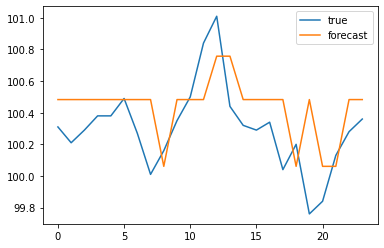

In [43]:
param_grid = {'max_depth': [1, 2, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 50, 100],
              'max_leaf_nodes': [10, 20, 30, 500, 1000]}
print("Parameter grid:\n{}".format(param_grid))

GSDT = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=30)
GSDT.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSDT.score(X_test, y_test)))
print("Best parameters: {}".format(GSDT.best_params_))
print("Best estimator:\n{}".format(GSDT.best_estimator_))

# make predictions
GSDT_forecast = GSDT.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSDT_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSDT_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSDT_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSDT.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSDT.score(X_test, y_test)))

result['GSDT']=pd.DataFrame(np.array(GSDT_forecast), index = test.index, columns=['GSDT'])

result_GSDT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSDT', 
                'rmse': mean_squared_error(y_test, GSDT_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSDT, ignore_index = True) 
result_rmse

# **Random Forest**

rmse: 0.25256
normed rmse: 0.252%
Accuracy on training set: 0.936
Accuracy on test set: 0.064


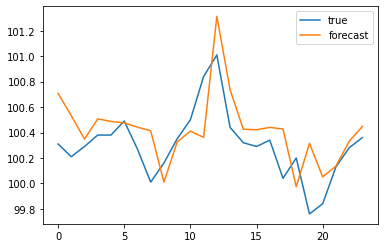

In [44]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=500, random_state=42)
RFmodel.fit(X_train, y_train)
forecast = RFmodel.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.3f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(RFmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RFmodel.score(X_test, y_test)))

In [45]:
result['Random Forest']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Random Forest'])
result_RF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'RF', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RF, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749
7,month,[RF],2019-12-01,2018-01-01,24,DT,0.331551
8,month,[RF],2019-12-01,2018-01-01,24,GSDT,0.264938
9,month,[RF],2019-12-01,2018-01-01,24,RF,0.252561


In [46]:
RFmodel.feature_importances_

array([0.02456003, 0.35503498, 0.08987857, 0.01787152, 0.24055415,
       0.0170798 , 0.02235588, 0.03272327, 0.03035328, 0.01838653,
       0.02706295, 0.01317881, 0.01124154, 0.01214206, 0.04510034,
       0.02661391, 0.01586237])

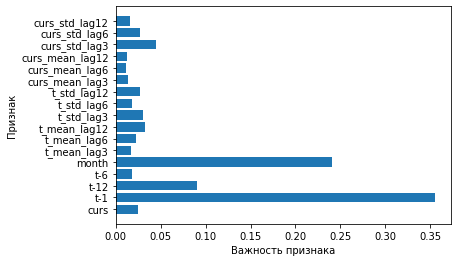

In [47]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(RFmodel)

# **GSRF**

Parameter grid:
{'n_estimators': [1, 10, 50, 100, 200, 300]}
Test set score: 0.04
Best parameters: {'n_estimators': 100}
Best estimator:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rmse: 0.2551
normed rmse: 0.2543%
Accuracy on training set: 0.939
Accuracy on test set: 0.045


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749
7,month,[RF],2019-12-01,2018-01-01,24,DT,0.331551
8,month,[RF],2019-12-01,2018-01-01,24,GSDT,0.264938
9,month,[RF],2019-12-01,2018-01-01,24,RF,0.252561


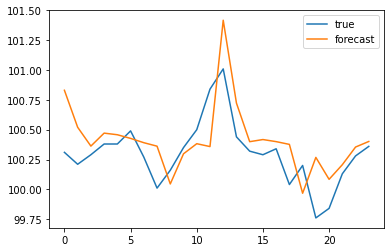

In [48]:
param_grid = {'n_estimators': [1, 10, 50, 100, 200, 300]}
print("Parameter grid:\n{}".format(param_grid))

GSRF = GridSearchCV(RandomForestRegressor(), param_grid, cv=30)
GSRF.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSRF.score(X_test, y_test)))
print("Best parameters: {}".format(GSRF.best_params_))
print("Best estimator:\n{}".format(GSRF.best_estimator_))

# make predictions
GSRF_forecast = GSRF.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSRF_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSRF_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSRF_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSRF.score(X_test, y_test)))

result['GSRF']=pd.DataFrame(np.array(GSRF_forecast), index = test.index, columns=['GSRF'])

result_GSRF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSRF', 
                'rmse': mean_squared_error(y_test, GSRF_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSRF, ignore_index = True) 
result_rmse

# **Slide test**

In [49]:
"""
from datetime import datetime
from dateutil.relativedelta import relativedelta
#startdate = pd.to_datetime(data_do)
startdate = pd.to_datetime(train_do)+ relativedelta(months=1)

#print('Today: ', startdate.strftime('%Y-%m-%d'))
#print(date_after_month.strftime('%Y-%m-%d'))
#startdate = str(startdate)[:10]
startdate
"""

"\nfrom datetime import datetime\nfrom dateutil.relativedelta import relativedelta\n#startdate = pd.to_datetime(data_do)\nstartdate = pd.to_datetime(train_do)+ relativedelta(months=1)\n\n#print('Today: ', startdate.strftime('%Y-%m-%d'))\n#print(date_after_month.strftime('%Y-%m-%d'))\n#startdate = str(startdate)[:10]\nstartdate\n"

In [50]:
"""
#forecast = RFmodel.predict(X_test)
#slide_test = test[test.index == train_do][data_not.columns.values].values
#print(slide_test)
slide_test = X_test
forecast = []
forecast.append(RFmodel.predict(slide_test)[0])

for i in range(test.shape[0] - 1):
  
  slide_test_next = slide_test.copy()
  slide_test_next[0, 1] = forecast[-1]

  slide_test_next[0, 0] += 1
  slide_test_next[0, 2:] = slide_test[0, 1:-1]
  
  #print(slide_test_next)
  slide_test = slide_test_next.copy()

  forecast.append(RFmodel.predict(slide_test)[0])

forecast = np.array(forecast)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))
"""

"\n#forecast = RFmodel.predict(X_test)\n#slide_test = test[test.index == train_do][data_not.columns.values].values\n#print(slide_test)\nslide_test = X_test\nforecast = []\nforecast.append(RFmodel.predict(slide_test)[0])\n\nfor i in range(test.shape[0] - 1):\n  \n  slide_test_next = slide_test.copy()\n  slide_test_next[0, 1] = forecast[-1]\n\n  slide_test_next[0, 0] += 1\n  slide_test_next[0, 2:] = slide_test[0, 1:-1]\n  \n  #print(slide_test_next)\n  slide_test = slide_test_next.copy()\n\n  forecast.append(RFmodel.predict(slide_test)[0])\n\nforecast = np.array(forecast)\n\nplt.plot(y_test, label='true')\nplt.plot(forecast, label='forecast')\nplt.legend()\n\nprint('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))\nprint('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))\n"

In [51]:
"""result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RFST, ignore_index = True) 
result_rmse
"""

"result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', \n                'rmse': mean_squared_error(y_test, forecast) ** 0.5} \nresult_rmse = result_rmse.append(result_RFST, ignore_index = True) \nresult_rmse\n"

# **Stratified K-Fold cross-validation and other strategies**

In [52]:
"""
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)

print("Cross-validation scores:\n{}".format(
      cross_val_score(model, X_train, y_train, cv=kfold)))

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
print("Cross-validation scores:\n{}".format(
    cross_val_score(model, X_train, y_train, cv=kfold)))
"""

'\nfrom sklearn.model_selection import KFold\nkfold = KFold(n_splits=3)\n\nprint("Cross-validation scores:\n{}".format(\n      cross_val_score(model, X_train, y_train, cv=kfold)))\n\nkfold = KFold(n_splits=3, shuffle=True, random_state=42)\nprint("Cross-validation scores:\n{}".format(\n    cross_val_score(model, X_train, y_train, cv=kfold)))\n'

# **GradientBoostingRegressor**

In [53]:
from xgboost import XGBRegressor

rmse: 0.4136
normed rmse: 0.4123%
Accuracy on training set: -0.184
Accuracy on test set: -1.510


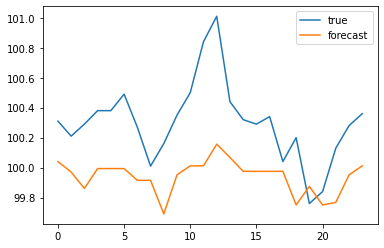

In [54]:
xgb_model = XGBRegressor (objective ='reg:squarederror', n_estimators=50, max_depth=3)
xgb_model.fit(X_train, y_train, verbose=False)
# make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_model.feature_importances_
plt.plot(y_test, label='true')
plt.plot(xgb_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, xgb_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, xgb_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

In [55]:
result['GradientBoosting']=pd.DataFrame(np.array(xgb_forecast), index = test.index, columns=['GradientBoosting'])
result_XGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'XGB', 
                'rmse': mean_squared_error(y_test, xgb_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_XGB, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749
7,month,[RF],2019-12-01,2018-01-01,24,DT,0.331551
8,month,[RF],2019-12-01,2018-01-01,24,GSDT,0.264938
9,month,[RF],2019-12-01,2018-01-01,24,RF,0.252561


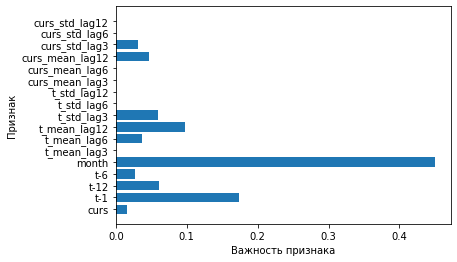

In [56]:
plot_features(xgb_model)

# **Grid Search XGB**

In [57]:
?GridSearchCV

Parameter grid:
{'max_depth': [1, 2, 3, 5], 'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
Test set score: -0.06
Best parameters: {'max_depth': 1, 'n_estimators': 100}
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
rmse: 0.2693
normed rmse: 0.2685%
Accuracy on training set: 0.700
Accuracy on test set: -0.064


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749
7,month,[RF],2019-12-01,2018-01-01,24,DT,0.331551
8,month,[RF],2019-12-01,2018-01-01,24,GSDT,0.264938
9,month,[RF],2019-12-01,2018-01-01,24,RF,0.252561


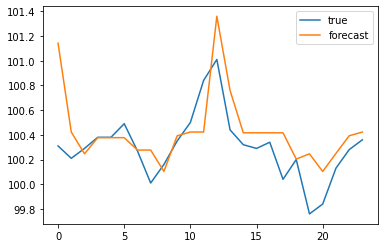

In [58]:
param_grid = {'max_depth': [1, 2, 3, 5],
              'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
print("Parameter grid:\n{}".format(param_grid))

GSXGB = GridSearchCV(XGBRegressor(objective ='reg:squarederror'), param_grid, cv=30)
GSXGB.fit(X_train, y_train, verbose=False)

print("Test set score: {:.2f}".format(GSXGB.score(X_test, y_test)))
print("Best parameters: {}".format(GSXGB.best_params_))
print("Best estimator:\n{}".format(GSXGB.best_estimator_))

# make predictions
GSXGB_forecast = GSXGB.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSXGB_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSXGB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSXGB.score(X_test, y_test)))

result['GSXGB']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GSXGB'])

result_GSXGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSXGB', 
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSXGB, ignore_index = True) 
result_rmse

# **Results**

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[RF],2019-12-01,2018-01-01,24,ARIMA,0.259064
1,month,[RF],2019-12-01,2018-01-01,24,ARIMAX,0.405906
2,month,[RF],2019-12-01,2018-01-01,24,KNR,0.287534
3,month,[RF],2019-12-01,2018-01-01,24,OLS,0.356129
4,month,[RF],2019-12-01,2018-01-01,24,Ridge,0.356090
5,month,[RF],2019-12-01,2018-01-01,24,Lasso,0.244286
6,month,[RF],2019-12-01,2018-01-01,24,ElasticNet,0.251749
7,month,[RF],2019-12-01,2018-01-01,24,DT,0.331551
8,month,[RF],2019-12-01,2018-01-01,24,GSDT,0.264938
9,month,[RF],2019-12-01,2018-01-01,24,RF,0.252561


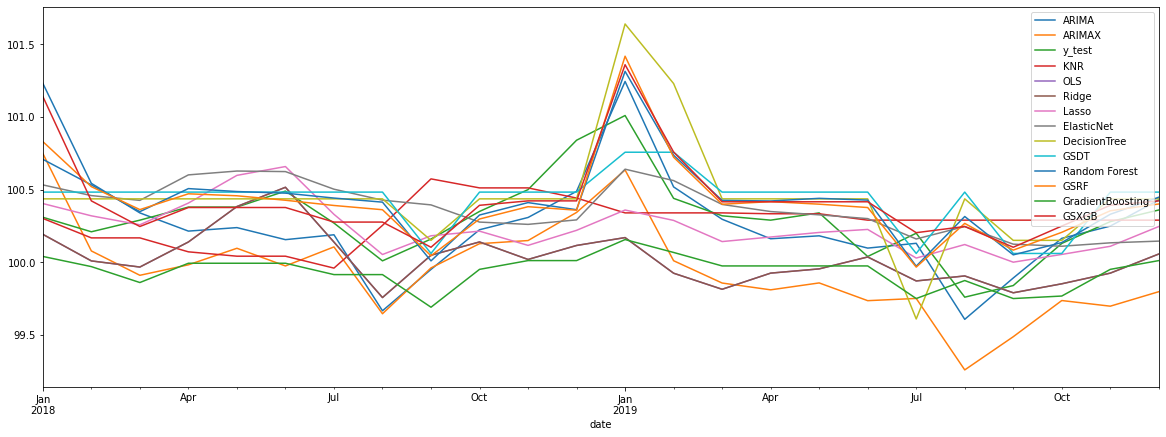

In [59]:
result.plot(figsize=(20, 7))
result_rmse